In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import *
from tqdm import tqdm
from utils import LoadRumoursDataset,LoadRumoursDatasetFilterNode
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pylab as plt
import uuid
from tqdm import tqdm
import seaborn as sns

In [2]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("spyder-experiment")
import mlflow.pytorch
mlflow.set_experiment("GradientBoosting 2024-08-29 SMOTE Filter Node 17min-3days")

2024/09/29 14:20:26 INFO mlflow.tracking.fluent: Experiment with name 'GradientBoosting 2024-08-29 SMOTE Filter Node 17min-3days' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/azureuser/rumour-detection-pheme/mlruns/32', creation_time=1727619626140, experiment_id='32', last_update_time=1727619626140, lifecycle_stage='active', name='GradientBoosting 2024-08-29 SMOTE Filter Node 17min-3days', tags={}>

In [3]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"


### SMOTE APPROACH

In [5]:
time_cut =1e10
processor = LoadRumoursDatasetFilterNode(file_path_replies, file_path_posts, time_cut)
processor.load_data()
processor.process_data()
df_final = processor.get_final_dataframe()


In [7]:
df_final.head()

,followers,favorite_count,retweet_count,rumour,embeddings_avg,replies,first_time_diff,no_verified,verified
0,-0.073004,-0.532290,-0.160000,1,"[-0.12270056130364537, 0.01583862374536693, -0...",5,3.510619,1,0
1,0.031065,-0.344423,1.293333,1,"[-0.12335950043052435, -0.055849663292368255, ...",5,0.999077,0,1
2,0.356672,-0.524462,-0.302222,1,"[-0.1364929385483265, -0.07159566258390744, -0...",5,0.740536,0,1
3,0.332156,-0.524462,-0.400000,1,"[-0.045377860377941816, -0.20127306692302227, ...",3,-0.164358,0,1
4,1.046022,-0.391389,0.964444,1,"[-0.03706469060853124, -0.1309182441327721, -0...",10,-0.352724,0,1


In [6]:
X  = df_final.drop(columns=['rumour'])
X = np.hstack([X.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X.embeddings_avg.tolist()))])
#X = np.hstack([X.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X.embeddings_avg.tolist()))])
y =df_final['rumour']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y,shuffle=True
)

In [9]:
print(y_train.sum(),y_train.shape)

357 (1601,)


In [10]:
print(y_test.sum(),y_test.shape)

90 (401,)


In [7]:
# Apply SMOTE to the features without embeddings
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42,sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

#### Hyperparameter tunning

In [8]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Define the hyperparameter distributions
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': np.linspace(0.01, 0.1, 10),
    'max_depth': [3, 4, 5, 6],
    'subsample': np.linspace(0.6, 0.9, 4),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

# Create the XGBoost model object
gb_model = GradientBoostingClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(gb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='recall')


In [9]:
# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_resampled, y_resampled)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

KeyboardInterrupt: 

#### Parameter Details:
* n_estimators: Number of boosting stages to be run (50 to 200).
* learning_rate: Shrinks the contribution of each tree to prevent overfitting (between 0.01 and 0.1).
* max_depth: Maximum depth of individual trees (3 to 6).
* subsample: Fraction of samples to be used for fitting individual base learners (60% to 90%).
* min_samples_split: Minimum number of samples required to split a node.
* min_samples_leaf: Minimum number of samples required to be at a leaf node.
* max_features: Number of features to consider for the best split.

In [17]:
best_params = random_search.best_params_

In [18]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

def modelfit(alg, X_train, y_train, X_test, y_test, performCV=True, printFeatureImportance=True, cv_folds=5):
    # Fit the algorithm on the data
    #alg.fit(X_train, y_train)
        
    # Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]

    # Predict test set:
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)[:,1]
    
    # Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='recall')
    
    # Print model report for Train:
    print("\nModel Report Train")
    print("AUC Score : %f" % roc_auc_score(y_train, dtrain_predprob))
    print("Accuracy : %.4g" % accuracy_score(y_train, dtrain_predictions))
    print("Precision : %.4g" % precision_score(y_train, dtrain_predictions))
    print("Recall : %f" % recall_score(y_train, dtrain_predictions))
    
    # Plot confusion matrix for Train
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_train, dtrain_predictions), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Train")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    # Print model report for Test:
    print("\nModel Report Test")
    print("AUC Score : %f" % roc_auc_score(y_test, dtest_predprob))
    print("Accuracy : %.4g" % accuracy_score(y_test, dtest_predictions))
    print("Precision : %.4g" % precision_score(y_test, dtest_predictions))
    print("Recall : %f" % recall_score(y_test, dtest_predictions))
    
    # Plot confusion matrix for Test
    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_test, dtest_predictions), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Test")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.tight_layout()
    plt.show()
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

    return alg



In [19]:
# Train the final model with the best hyperparameters
final_model = GradientBoostingClassifier(
    **best_params
)
final_model.fit(X_resampled, y_resampled)


GradientBoostingClassifier(learning_rate=0.06000000000000001, max_depth=6,
                           min_samples_split=5, n_estimators=200,
                           subsample=0.8)


Model Report Train
AUC Score : 1.000000
Accuracy : 1
Precision : 1
Recall : 1.000000

Model Report Test
AUC Score : 0.912504
Accuracy : 0.8479
Precision : 0.6306
Recall : 0.777778


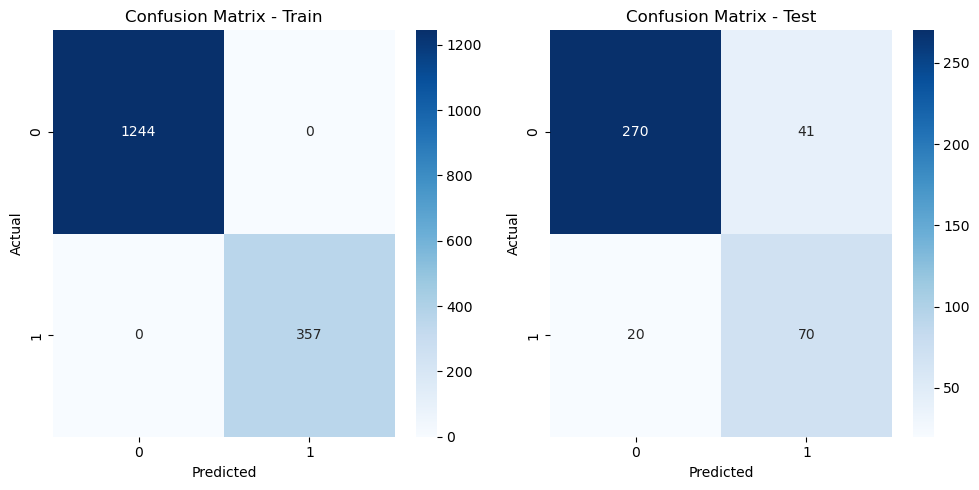

CV Score : Mean - 0.6553208 | Std - 0.05393161 | Min - 0.5633803 | Max - 0.7183099


GradientBoostingClassifier(learning_rate=0.06000000000000001, max_depth=6,
                           min_samples_split=5, n_estimators=200,
                           subsample=0.8)

In [20]:
modelfit(final_model,X_train, y_train,X_test,y_test)

#### Without SMOTE

In [21]:
# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'subsample': 0.6, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 4, 'learning_rate': 0.030000000000000006}
Best score:  0.6244913928012519


In [22]:
# Train the final model with the best hyperparameters
final_model = GradientBoostingClassifier(
    **best_params
)
final_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.06000000000000001, max_depth=6,
                           min_samples_split=5, n_estimators=200,
                           subsample=0.8)